In [139]:
import time
import datetime
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.dummy import DummyRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
SEED = 26042001

In [140]:
df_train = pd.read_csv('NaN_OneHot/processed_data_train.csv')
df_valid = pd.read_csv('NaN_OneHot/processed_data_valid.csv')
df_test = pd.read_csv('NaN_OneHot/processed_data_test.csv')
tf_idf_ds = pd.read_csv('data/processed_data/tf-idf.ivan.csv')
df_train_united = df_train.join(tf_idf_ds, how='inner', on='Unnamed: 0',lsuffix='_left', rsuffix='_right')
df_valid_united = df_valid.join(tf_idf_ds, how='inner', on='Unnamed: 0',lsuffix='_left', rsuffix='_right')
df_test_united = df_test.join(tf_idf_ds, how='inner', on='Unnamed: 0',lsuffix='_left', rsuffix='_right')

In [141]:
df_train_united = df_train_united.drop(columns=['Unnamed: 0', 'Unnamed: 0_left', 'case_idx', 'NARRATIVE'])
df_test_united = df_test_united.drop(columns=['Unnamed: 0', 'Unnamed: 0_left', 'case_idx', 'NARRATIVE'])
df_valid_united = df_valid_united.drop(columns=['Unnamed: 0', 'Unnamed: 0_left', 'case_idx', 'NARRATIVE'])

In [143]:
df_train_united.nunique().sort_values(ascending=False)[500:].head(25) # 500 pierwszych kolumn to są PC z PCA kolumny NARRATIVE.
# df_test_united.nunique().sort_values(ascending=False)[500:].head(25) # 500 pierwszych kolumn to są PC z PCA kolumny NARRATIVE.
# df_valid_united.nunique().sort_values(ascending=False)[500:].head(25) # 500 pierwszych kolumn to są PC z PCA kolumny NARRATIVE.

narrative_tfidf-PC-1                                                   4854
case_lat                                                               4689
case_lon                                                               4688
inst_age_in_days                                                       3203
TAVG                                                                   3090
case_date                                                              2968
accident_pressure_as_%_mop_psig                                        2367
UNINTENTIONAL_RELEASE_BBLS                                             2015
EST_COST_PROP_DAMAGE                                                   1610
EST_COST_EMERGENCY                                                     1310
EST_COST_GAS_RELEASED                                                   839
MOP_PSIG                                                                762
EST_COST_ENVIRONMENTAL                                                  651
INTENTIONAL_

In [144]:
df_train_united.loc[:, df_train_united.dtypes == np.dtype('O')]

,case_date
0,2021-02-11
1,2017-12-12
2,2022-05-04
3,2022-09-20
4,2014-08-04
...,...
4875,2013-04-05
4876,2012-05-08
4877,2020-09-09
4878,2019-10-03


In [145]:
df_train_united['case_date'] = df_train_united['case_date'].apply(lambda date: time.mktime(datetime.datetime.strptime(date, "%Y-%m-%d").timetuple()) / 86400)
df_valid_united['case_date'] = df_valid_united['case_date'].apply(lambda date: time.mktime(datetime.datetime.strptime(date, "%Y-%m-%d").timetuple()) / 86400)
df_test_united['case_date'] = df_test_united['case_date'].apply(lambda date: time.mktime(datetime.datetime.strptime(date, "%Y-%m-%d").timetuple()) / 86400)

In [146]:
df_train_united['case_date']

0       18668.958333
1       17511.958333
2       19115.916667
3       19254.916667
4       16285.916667
            ...     
4875    15799.916667
4876    15467.916667
4877    18513.916667
4878    18171.916667
4879    16682.916667
Name: case_date, Length: 4880, dtype: float64

dodajemy roczną cykliczność naszym danym 

In [147]:
df_train_united['case_date_sin'] = np.sin(2*np.pi * df_train_united['case_date'] / 365)
df_valid_united['case_date_sin'] = np.sin(2*np.pi * df_valid_united['case_date'] / 365)
df_test_united['case_date_sin'] = np.sin(2*np.pi * df_test_united['case_date'] / 365)

In [148]:
df_test_united.apply(lambda col: (col == np.inf).sum()).sort_values(ascending=False)

case_lat                  0
narrative_tfidf-PC-253    0
narrative_tfidf-PC-255    0
narrative_tfidf-PC-256    0
narrative_tfidf-PC-257    0
                         ..
narrative_tfidf-PC-21     0
narrative_tfidf-PC-22     0
narrative_tfidf-PC-23     0
narrative_tfidf-PC-24     0
case_date_sin             0
Length: 722, dtype: int64

In [149]:
df_valid_united.isna().sum().sort_values(ascending=False)

case_lat                  0
narrative_tfidf-PC-253    0
narrative_tfidf-PC-255    0
narrative_tfidf-PC-256    0
narrative_tfidf-PC-257    0
                         ..
narrative_tfidf-PC-21     0
narrative_tfidf-PC-22     0
narrative_tfidf-PC-23     0
narrative_tfidf-PC-24     0
case_date_sin             0
Length: 722, dtype: int64

In [150]:
df_train_united[df_train_united['accident_pressure_as_%_mop_psig'] == np.inf] = 5.56553
df_valid_united[df_valid_united['accident_pressure_as_%_mop_psig'] == np.inf] = 5.56553
df_test_united[df_test_united['accident_pressure_as_%_mop_psig'] == np.inf] = 5.56553

In [151]:
df_train_united[df_train_united['accident_pressure_as_%_mop_psig'] == 5.56553] = df_train_united['accident_pressure_as_%_mop_psig'].max()
df_valid_united[df_valid_united['accident_pressure_as_%_mop_psig'] == 5.56553] = df_valid_united['accident_pressure_as_%_mop_psig'].max()
df_test_united[df_test_united['accident_pressure_as_%_mop_psig'] == 5.56553] = df_test_united['accident_pressure_as_%_mop_psig'].max()

**DANE ZOSTAŁY PRZETWARZONE!**

Będziemy przywidywać `inst_age_in_days`, czyli oszacowany koszt szkód majątkowych. Oczywiście to jest zadanie typu regressii. </br> 
Najpierw rozdzielimy nasze dane i weźmiemy stosunek train/test/valid = 0.6/0.2/0.2.   

In [170]:
X_train, y_train = df_train_united.drop(columns=['inst_age_in_days']), df_train_united['inst_age_in_days']
X_valid, y_valid = df_valid_united.drop(columns=['inst_age_in_days']), df_valid_united['inst_age_in_days']
X_test, y_test = df_test_united.drop(columns=['inst_age_in_days']), df_test_united['inst_age_in_days']

Określijmy sobie poziom odniesienia jako "zawsze przywidujemy średnią" oraz załóżmy RMSE oraz R2 jako metrykę dla naszego regressora. <br/>

In [171]:
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train, y_train)
y_dummy_pred = dummy.predict(X_valid)
print(f'R2 of a dummy regressor is {r2_score(y_valid, y_dummy_pred)}')
print(f'RMSE of a dummy regressor is {
      mean_squared_error(y_valid, y_dummy_pred) ** 0.5}')

R2 of a dummy regressor is -0.0009993937234309413
RMSE of a dummy regressor is 7829.513026521421


Zastosujemy regresję linijową jako high-bias/low-variance model. 

In [172]:
linear_regressor = LinearRegression()
lin_reg = linear_regressor.fit(X_train, y_train)
y_lin_reg_pred = lin_reg.predict(X_valid)
print(f'R2 of a linear regressor is {r2_score(y_valid, y_lin_reg_pred)}')
print(f'RMSE of a linear regressor is {
      mean_squared_error(y_valid, y_lin_reg_pred) ** 0.5}')

R2 of a linear regressor is -1476897889.609733
RMSE of a linear regressor is 300741304.2939046


Zastosujemy regresję typu low bias/high variance poprzez zastosowanie drzew decyzyjnych.

In [159]:
regression_tree = DecisionTreeRegressor()
regression_tree.fit(X_train, y_train)
y_tree_pred = regression_tree.predict(X_valid)
print(f'R2 of a tree regressor is {r2_score(y_valid, y_tree_pred)}')
print(f'RMSE of a tree regressor is {
      mean_squared_error(y_valid, y_tree_pred) ** 0.5}')

R2 of a tree regressor is -0.4266928666456453
RMSE of a tree regressor is 9347.233433574993


To już nie jest aż tak źle. Sprobujmy znaleźć hyperparametry.

In [160]:
regression_tree = DecisionTreeRegressor(random_state=SEED)
params = {'min_samples_leaf': np.arange(13, 18, 1), 'max_depth': [4, 5, 6, 7]}
gsCV = GridSearchCV(regression_tree, params)
gsCV.fit(X_train, y_train)
y_tree_pred = gsCV.predict(X_valid)
print(f'R2 of a tree regressor is {r2_score(y_valid, y_tree_pred)}')
print(f'RMSE of a tree regressor is {
      mean_squared_error(y_valid, y_tree_pred) ** 0.5}')

R2 of a tree regressor is 0.2737711119558065
RMSE of a tree regressor is 6668.906122925472


In [162]:
gsCV.best_params_

{'max_depth': 4, 'min_samples_leaf': 17}

In [163]:
regression_tree_opt = DecisionTreeRegressor(max_depth= 4, min_samples_leaf= 17, random_state=SEED)
regression_tree_opt.fit(X_train, y_train)
y_opt_tree_pred = regression_tree_opt.predict(X_valid)
print(f'R2 of a tree regressor optimized is {r2_score(y_valid, y_tree_pred)}')
print(f'RMSE of a tree regressor optimized is {
      mean_squared_error(y_valid, y_tree_pred) ** 0.5}')

R2 of a tree regressor optimized is 0.2737711119558065
RMSE of a tree regressor optimized is 6668.906122925472


[Text(0.5, 0.9, 'INCIDENT_AREA_TYPE_UNDERGROUND <= 0.5\nsquared_error = 62217172.143\nsamples = 4880\nvalue = 11072.94'), Text(0.25, 0.7, 'MOP_PSIG <= 1306.5\nsquared_error = 45057718.489\nsamples = 2973\nvalue = 8741.207'), Text(0.125, 0.5, 'MATERIAL_INVOLVED_MATERIAL OTHER THAN CARBON STEEL <= 0.5\nsquared_error = 44610773.052\nsamples = 2375\nvalue = 9572.408'), Text(0.0625, 0.3, 'EST_COST_PROP_DAMAGE <= 23633.5\nsquared_error = 43858113.416\nsamples = 2044\nvalue = 10133.998'), Text(0.03125, 0.1, 'squared_error = 38951070.211\nsamples = 1600\nvalue = 9516.82'), Text(0.09375, 0.1, 'squared_error = 55222031.508\nsamples = 444\nvalue = 12358.065'), Text(0.1875, 0.3, 'SYSTEM_PART_INVOLVED_nan <= 0.5\nsquared_error = 35284394.18\nsamples = 331\nvalue = 6104.461'), Text(0.15625, 0.1, 'squared_error = 36243736.445\nsamples = 293\nvalue = 5460.085'), Text(0.21875, 0.1, 'squared_error = -0.0\nsamples = 38\nvalue = 11072.94'), Text(0.375, 0.5, 'ON_OFF_SHORE_ONSHORE <= 0.5\nsquared_error = 33

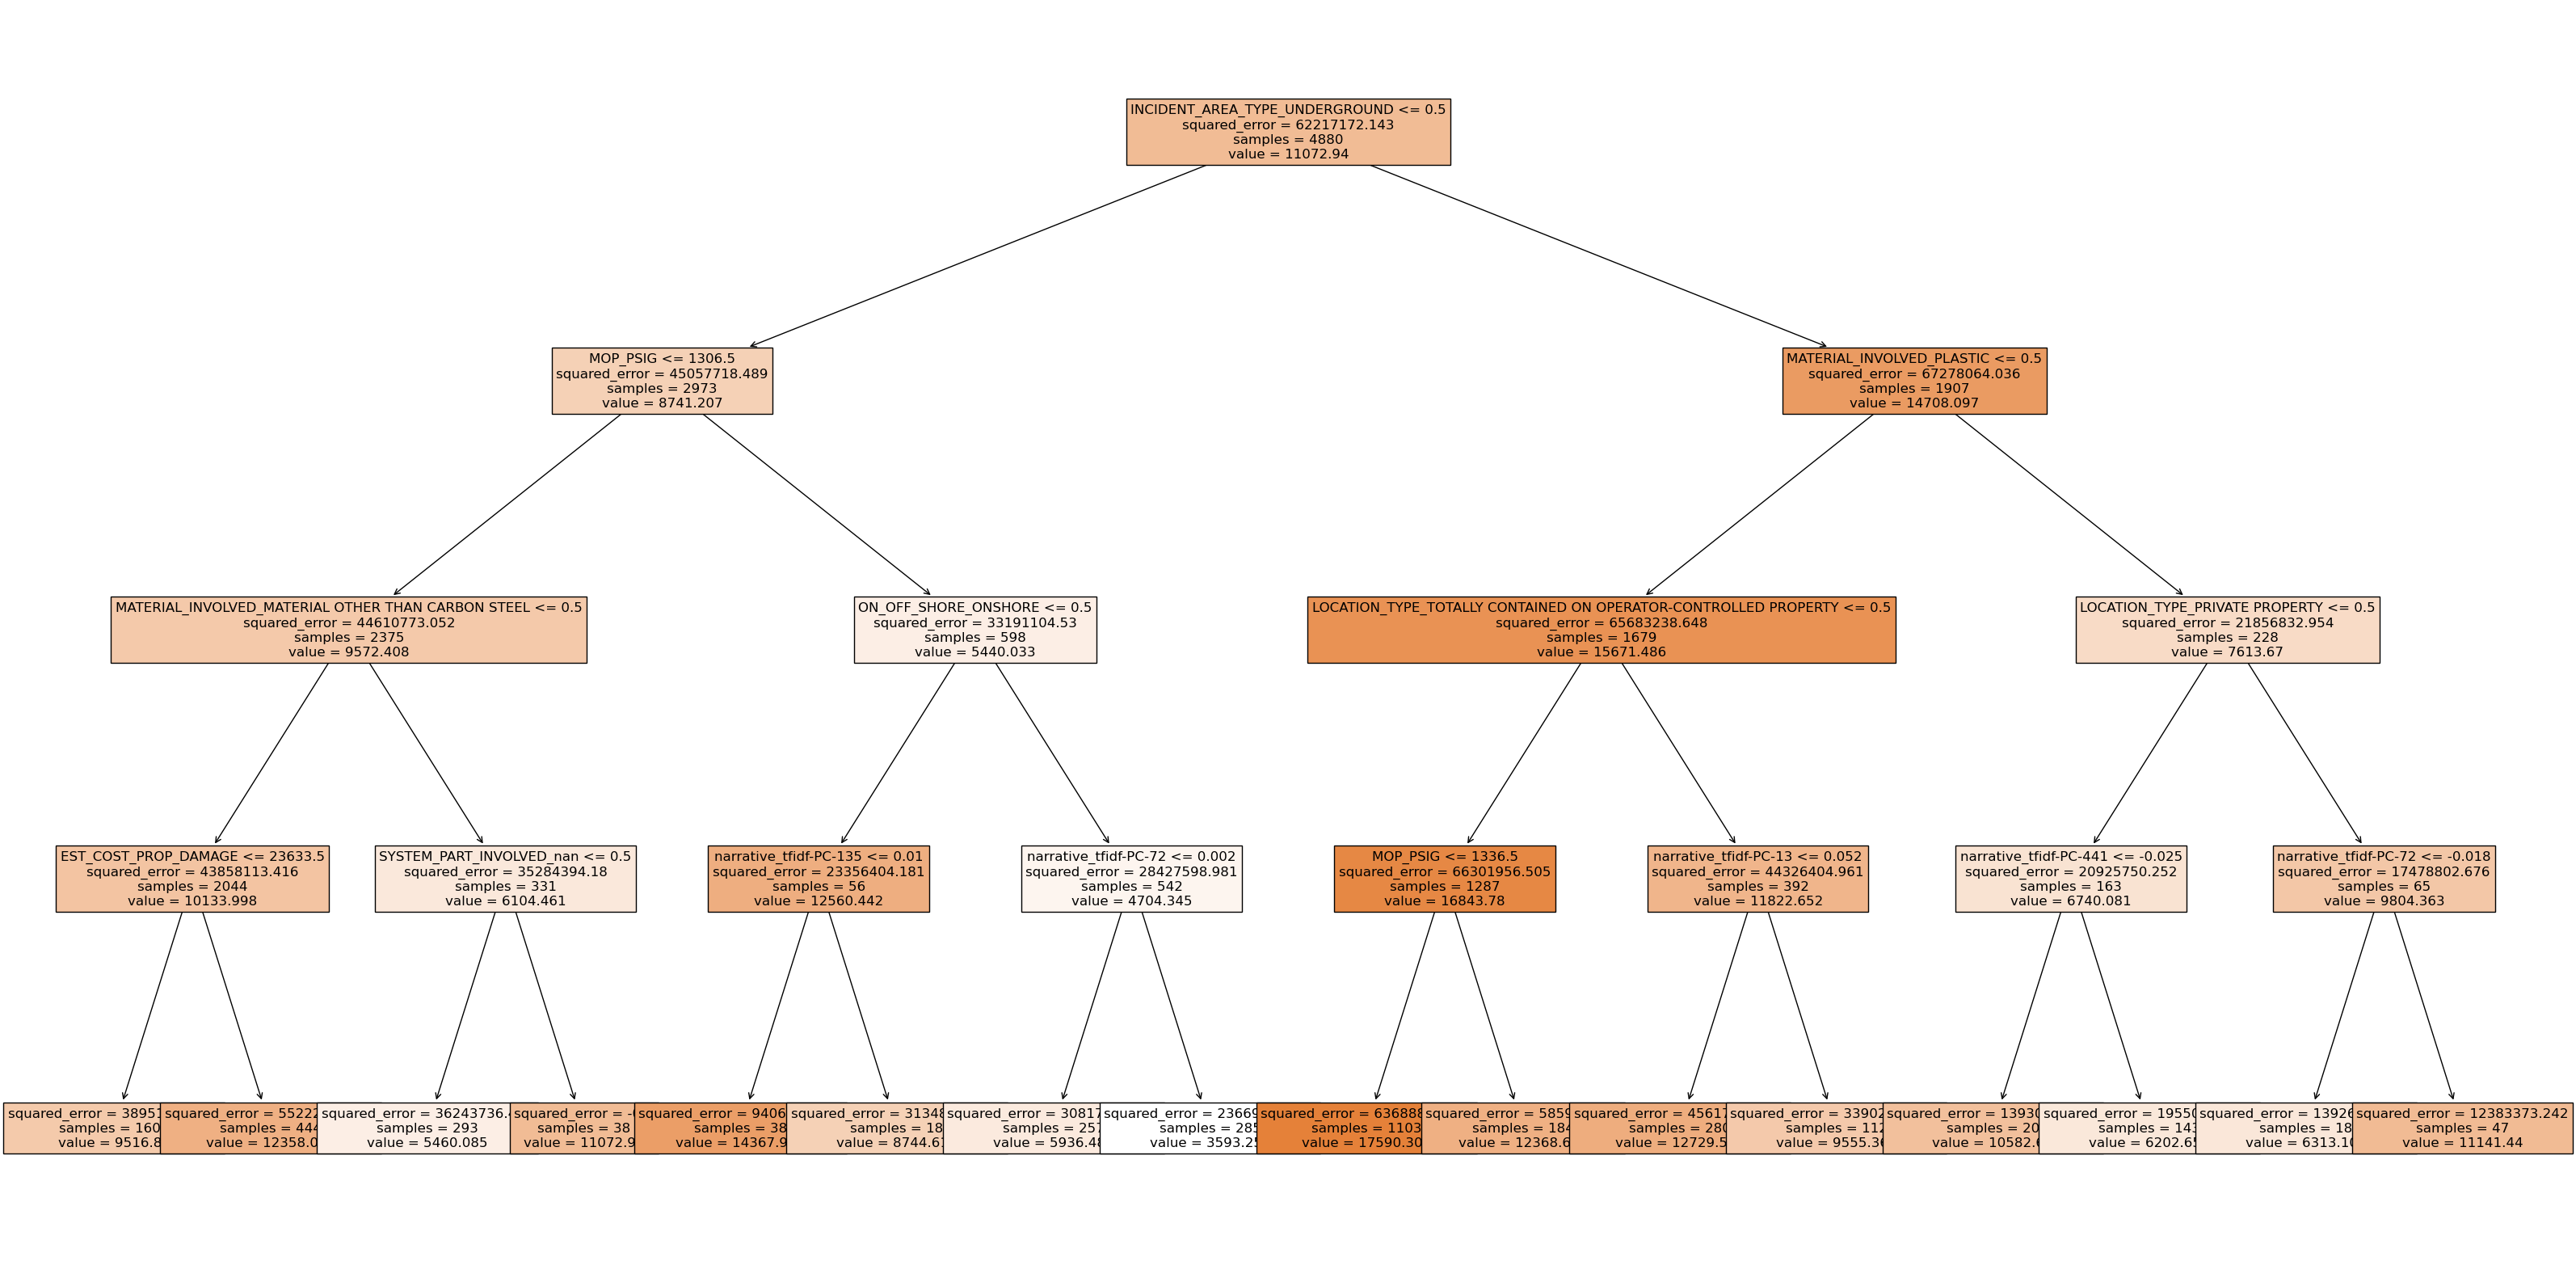

In [164]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
fig.set_size_inches(40, 20)
print(plot_tree(regression_tree_opt, filled=True,feature_names=X_valid.columns.values, fontsize=12))

In [165]:
rand_forest_regressor = RandomForestRegressor(n_estimators=100, max_depth = 10, min_samples_leaf=17, random_state=SEED)
rand_forest_regressor.fit(X_train, y_train)
y_rand_forest_pred = rand_forest_regressor.predict(X_valid)
print(f'R2 of a random forest regressor is {r2_score(y_valid, y_rand_forest_pred)}')
print(f'RMSE of a random forest regressor is {
      mean_squared_error(y_valid, y_rand_forest_pred) ** 0.5}')

R2 of a random forest regressor is 0.3379623323803368
RMSE of a random forest regressor is 6367.3569054536465


In [166]:
rand_forest_regressor = RandomForestRegressor(n_estimators=100, max_depth = 10, min_samples_leaf=17, random_state=SEED)
rand_forest_regressor.fit(X_train, y_train)
y_rand_forest_pred = rand_forest_regressor.predict(X_test)
print(f'R2 of a random forest regressor on a test dataset is {r2_score(y_test, y_rand_forest_pred)}')
print(f'RMSE of a random forest regressor on a test dataset is {
      mean_squared_error(y_test, y_rand_forest_pred) ** 0.5}')

R2 of a random forest regressor on a test dataset is 0.3415352024804732
RMSE of a random forest regressor on a test dataset is 6478.749859744504


In [167]:
svr = SVR()
tree = DecisionTreeRegressor(max_depth=4, min_samples_leaf=17)
stacking_regressor = StackingRegressor(estimators=[('svr', svr), ('tree', tree)], final_estimator=RandomForestRegressor(n_estimators=10, random_state=SEED))
stacking_regressor.fit(X_train, y_train)
y_stacking_pred = stacking_regressor.predict(X_valid)
print(f'R2 of a stacking regressor is {
      r2_score(y_valid, y_stacking_pred)}')
print(f'RMSE of a stacking regressor is {
      mean_squared_error(y_valid, y_stacking_pred) ** 0.5}')

R2 of a stacking regressor is -0.03577359467618102
RMSE of a stacking regressor is 7964.348609764258


In [168]:
from catboost import CatBoostRegressor
cb_regression = CatBoostRegressor(loss_function='RMSE', random_state=SEED)
cb_regression.fit(X_train, y_train, verbose=100)

Learning rate set to 0.052596
0:	learn: 7802.2669428	total: 101ms	remaining: 1m 41s
100:	learn: 5965.7128971	total: 1.72s	remaining: 15.3s
200:	learn: 5311.1723059	total: 3.41s	remaining: 13.5s
300:	learn: 4632.7693979	total: 5.43s	remaining: 12.6s
400:	learn: 4079.6373158	total: 7.19s	remaining: 10.7s
500:	learn: 3590.2402274	total: 8.9s	remaining: 8.86s
600:	learn: 3166.4523646	total: 10.7s	remaining: 7.12s
700:	learn: 2816.2512626	total: 12.8s	remaining: 5.47s
800:	learn: 2505.4592434	total: 14.5s	remaining: 3.6s
900:	learn: 2233.5398653	total: 16.3s	remaining: 1.79s
999:	learn: 1993.0307859	total: 18.1s	remaining: 0us


In [173]:
y_cb_pred = cb_regression.predict(X_test)
print(f'R2 of a catboost regressor is {r2_score(y_test, y_cb_pred)}')
print(f'RMSE of a catboost regressor is {
      mean_squared_error(y_valid, y_cb_pred) ** 0.5}')

R2 of a catboost regressor is 0.3876305555812223
RMSE of a catboost regressor is 9027.538367176834
